In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model, optimizers

2022-02-07 14:07:57.394128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-07 14:07:57.394169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
#Data Augmentation 
# Noise Injection 
#Shifting time 
#Changing the pitch 
#Speed 
# Time wrapping 
# Frequency Masking 
# Time Masking 

In [8]:
audio = "/home/divyansh/Divyansh/projects/senti_random_forest/data/"

In [9]:
audio_df = pd.read_csv('/home/divyansh/Divyansh/projects/senti_random_forest/audio.csv', usecols= ['emotion', 'path', 'gender', 'actor' ])

In [10]:
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/home/divyansh/Divyansh/projects/senti_random_...
1,male,fear,1,/home/divyansh/Divyansh/projects/senti_random_...
2,male,angry,1,/home/divyansh/Divyansh/projects/senti_random_...
3,male,happy,1,/home/divyansh/Divyansh/projects/senti_random_...
4,male,sad,1,/home/divyansh/Divyansh/projects/senti_random_...


In [13]:
train, test = train_test_split(audio_df, test_size=0.2, random_state= 0, 
                               stratify=audio_df[['emotion', 'gender', 'actor']])

In [14]:
X_train = train.iloc[:,3:]
y_train = train.iloc[:,:2].drop(columns = ['gender'])

In [15]:
print(X_train.shape)

(1152, 1)


Adding the noise, stretch, speed and Pitch to the audio file 


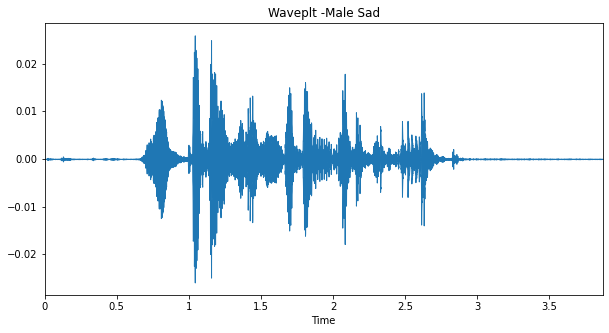

In [17]:
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'
x,sr = librosa.load(fname)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplt -Male Sad')
plt.savefig('Waveplot_MaleSad.png')

In [18]:
#Adding the noise 
def noise(x):
    noise_amp = 0.05* np.random.uniform()*np.amax(x)
    x = x.astype('float64') + noise_amp * np.random.normal(size = x.shape[0])
    return x

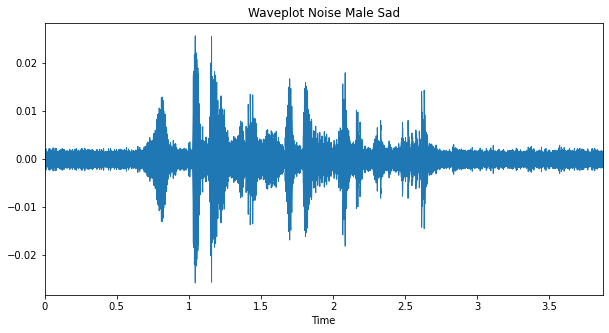

In [20]:
x = noise(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot Noise Male Sad')
plt.savefig('Wave_MaleSadNoise.png')

In [21]:
#function to stretch the sound 
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x,rate)
    return data


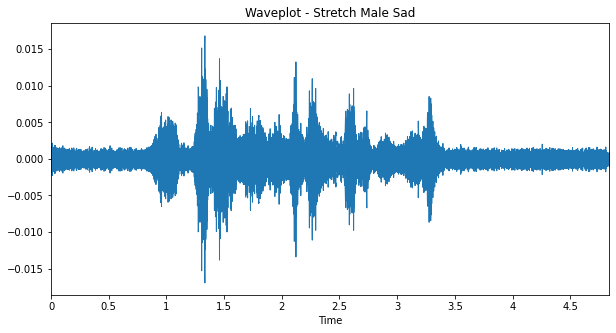

In [22]:
x = stretch(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')


In [28]:
#function to increase the speed and the pitch 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4/ length_change
    tmp = np.interp(np.arange(0,len(x), speed_fac), np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x*=0
    x[0:minlen] = tmp[0:minlen]
    return x

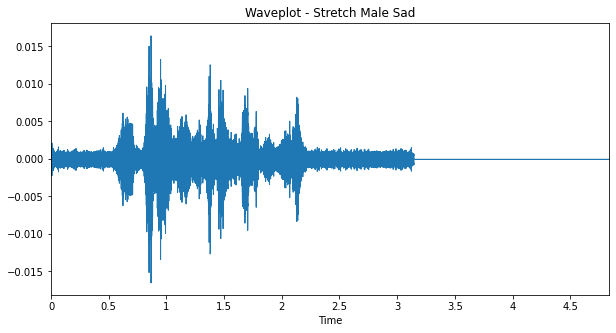

In [29]:
x = speedNpitch(x)
plt.figure(figsize=(10,5))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSpeedNPitch.png')


In [32]:
#Applying the Data Augmentation methods to train set 

df = pd.DataFrame(columns=['log_spec'])
counter = 0

for index,path in enumerate(train.path):
    #for the wave representation 
    X,sample_Rate = librosa.load(path, res_type='kaiser_fast', duration= 3, sr= 44100, offset= 0.5)
    spectogram = librosa.feature.melspectrogram(y=X, sr=sample_Rate, n_mels=128, fmax = 8000)
    db_spec = librosa.power_to_db(spectogram)
    log_spectogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectogram]
    counter += 1
print(len(df))
df.head()
    

1152


<bound method NDFrame.head of                                                log_spec
0     [-67.48485, -67.48485, -67.48485, -67.48485, -...
1     [-70.23177, -69.54781, -69.33392, -69.498695, ...
2     [-61.203438, -61.185642, -56.77076, -54.75769,...
3     [-45.199844, -43.82312, -44.344078, -45.735817...
4     [-70.07283, -69.86238, -69.91055, -69.819855, ...
...                                                 ...
1147  [-45.475925, -45.482555, -45.482555, -45.48255...
1148  [-66.68844, -66.651245, -67.55702, -67.57034, ...
1149  [-79.94437, -79.94437, -79.94437, -79.94437, -...
1150  [-79.74384, -78.55292, -78.47783, -78.20903, -...
1151  [-49.11234, -48.74086, -48.975597, -48.741455,...

[1152 rows x 1 columns]>

In [38]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()
    
    

1152


,feature
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [39]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-68.90387, -68.90387, -68.90387, -68.90387, -..."
1,"[-70.20399, -69.79468, -69.88852, -69.7777, -6..."
2,"[-63.878296, -59.9843, -57.37674, -60.590828, ..."
3,"[-47.082283, -46.432293, -48.122433, -47.82286..."
4,"[-69.90954, -69.828514, -69.689125, -69.65238,..."


In [40]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-67.48485, -67.48485, -67.48485, -67.48485, -..."
1,"[-70.23177, -69.54781, -69.33392, -69.498695, ..."
2,"[-61.203438, -61.185642, -56.77076, -54.75769,..."
3,"[-45.199844, -43.82312, -44.344078, -45.735817..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."
